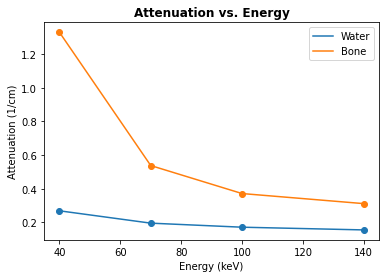

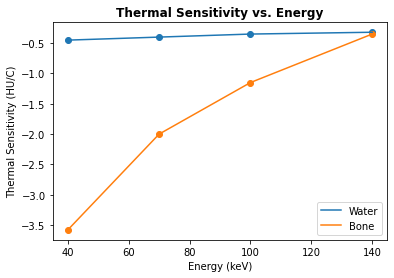

In [1]:
# DATA INITIALIZATION FOR SIMULATION

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import random
from sympy import *

# convert from HU to linear attenuation
def HU_to_mu(HU_values):
    return (HU_values / 1000) * water_mu[0] + water_mu[0]

# convert linear attenuation to HU
def mu_to_HU(attenuations):
    return ((attenuations - water_mu[0]) / water_mu[0]) * 1000

# source: https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/bone.html
df_bone = pd.read_excel('bone_attenuation_curve.xlsx')
df_water = pd.read_excel('water_attenuation_curve.xlsx')
x_bone = np.array(df_bone['energy (MeV)']) * 1000 # convert MeV to keV
y_bone = np.array(df_bone['mass attenuation (cm^2/g)'])
x_water = np.array(df_water['energy (MeV)']) * 1000
y_water = np.array(df_water['mass attenuation (cm^2/g)'])

water_mu = np.array([])
bone_mu = np.array([])

energy_levels = np.array([40, 70, 100, 140]) # in keV or kvP
num_energy_levels = energy_levels.size
bone_mu = np.interp(energy_levels, x_bone, y_bone) * 2 # density = 2g/cm^3
water_mu = np.interp(energy_levels, x_water, y_water)
water_HU = mu_to_HU(water_mu)
bone_HU = mu_to_HU(bone_mu)

# source: https://link.springer.com/content/pdf/10.1007/s00330-021-08206-z.pdf       
water_alphas_HU = np.array([0.45, 0.4, 0.35, 0.32]) * -1
bone_alphas_HU = np.array([3.58, 2, 1.15, 0.35]) * -1
water_alphas_mu = (water_alphas_HU / 1000) * water_mu[0] # convert from HU/C to 1/(cm * C)
bone_alphas_mu = (bone_alphas_HU / 1000) * water_mu[0]

# ----- GRAPHS -----

# attenuation vs. energy for water and bone
plt.plot(energy_levels, water_mu, label='Water')
plt.plot(energy_levels, bone_mu, label='Bone')

plt.title('Attenuation vs. Energy', fontweight='bold')
plt.xlabel('Energy (keV)')
plt.ylabel('Attenuation (1/cm)')
plt.legend()

plt.scatter(energy_levels, water_mu)
plt.scatter(energy_levels, bone_mu)
plt.show()

# thermal sensitivity vs. energy for water and bone
plt.plot(energy_levels, water_alphas_HU, label='Water')
plt.plot(energy_levels, bone_alphas_HU, label='Bone')

plt.title('Thermal Sensitivity vs. Energy', fontweight='bold')
plt.xlabel('Energy (keV)')
plt.ylabel('Thermal Sensitivity (HU/C)')
plt.legend()

plt.scatter(energy_levels, water_alphas_HU)
plt.scatter(energy_levels, bone_alphas_HU)
plt.show()

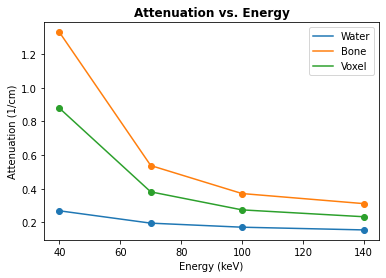

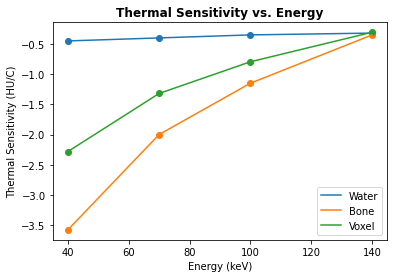

In [2]:
# VOXEL GENERATION

# generate the attenuations and thermal sensitivities
def generate_voxel(V_w, V_b): 
    voxel_mu = V_w * water_mu + V_b * bone_mu
    voxel_HU = mu_to_HU(voxel_mu)
    voxel_alphas_mu = V_w * water_alphas_mu + V_b * bone_alphas_mu
    voxel_alphas_HU = V_w * water_alphas_HU + V_b * bone_alphas_HU
                                       
    return voxel_mu, voxel_HU, voxel_alphas_mu, voxel_alphas_HU

# ----- GRAPHS -----
voxel_mu, voxel_HU, voxel_alphas_mu, voxel_alphas_HU = generate_voxel(0.3, 0.6)
                                       
# attenuation vs. energy for voxel, water, and bone
#plt.figure(figsize=(2, 2))
plt.plot(energy_levels, water_mu, label='Water')
plt.plot(energy_levels, bone_mu, label='Bone')
plt.plot(energy_levels, voxel_mu, label='Voxel')

plt.title('Attenuation vs. Energy', fontweight='bold')
plt.xlabel('Energy (keV)')
plt.ylabel('Attenuation (1/cm)')
plt.legend()

plt.scatter(energy_levels, water_mu)
plt.scatter(energy_levels, bone_mu)
plt.scatter(energy_levels, voxel_mu)
plt.show()

# thermal sensitivity vs. energy for voxel
plt.plot(energy_levels, water_alphas_HU, label='Water')
plt.plot(energy_levels, bone_alphas_HU, label='Bone')
plt.plot(energy_levels, voxel_alphas_HU, label='Voxel')

plt.title('Thermal Sensitivity vs. Energy', fontweight='bold')
plt.xlabel('Energy (keV)')
plt.ylabel('Thermal Sensitivity (HU/C)')
plt.legend()

plt.scatter(energy_levels, water_alphas_HU)
plt.scatter(energy_levels, bone_alphas_HU)
plt.scatter(energy_levels, voxel_alphas_HU)
plt.show()

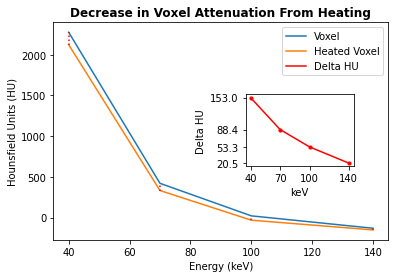

[2276.51882221  420.27581066   20.53671264 -131.71077152]


In [3]:
# VOXEL HEATING

# decreases voxel attenuation according to its thermal sensitivities
def heat_voxel(gt_temp, voxel_mu, t0_temp=23): 
    heated_voxel_mu = np.copy(voxel_mu)
    heated_voxel_mu += (gt_temp - t0_temp) * voxel_alphas_mu
    heated_voxel_HU = mu_to_HU(heated_voxel_mu)
    
    return heated_voxel_mu, heated_voxel_HU

heated_voxel_mu, heated_voxel_HU = heat_voxel(90, voxel_mu)
delta_HU = voxel_HU - heated_voxel_HU

# ----- GRAPHS -----

# attenuation vs. energy for voxel before and after heating
fig, ax = plt.subplots()
ax.plot(energy_levels, voxel_HU, label = 'Voxel')
ax.plot(energy_levels, heated_voxel_HU, label = 'Heated Voxel')
ax.plot(40, 0, color='red', label='Delta HU')
plt.title('Decrease in Voxel Attenuation From Heating', fontweight='bold')
plt.ylabel('Hounsfield Units (HU)')
plt.xlabel('Energy (keV)')
plt.vlines(energy_levels, heated_voxel_HU, voxel_HU, colors='red', linestyle='dotted')
plt.legend()

ax_new  = fig.add_axes([0.57, 0.38, 0.25, 0.25]) # x_0, y_0, height, width
ax_new.plot(energy_levels, delta_HU, color='red')
plt.scatter(energy_levels, delta_HU, color='red', s=10)
plt.xticks(energy_levels)
plt.yticks(delta_HU)
plt.xlabel('keV')
plt.ylabel('Delta HU')
    
plt.show()
print(voxel_HU)

In [19]:
# METHOD 1: TWO STEP ALGORITHM

# adds Gaussian random noise to measured attenuation values
def add_noise(heated_voxel_mu, heated_voxel_HU, delta_mu, delta_HU, error_level):
    random_err = np.random.normal(0, error_level)
    
    noisy_heated_voxel_HU = heated_voxel_HU + random_err
    noisy_heated_voxel_mu = HU_to_mu(noisy_heated_voxel_HU)
    
    #noisy_delta_HU = delta_HU + math.sqrt(2 * random_err ** 2) # error propagation
    noisy_delta_HU = delta_HU + random_err
    noisy_delta_mu = HU_to_mu(noisy_delta_HU)
    
    return noisy_heated_voxel_mu, noisy_heated_voxel_HU, noisy_delta_mu, noisy_delta_HU

voxel_mu, voxel_HU, voxel_alphas_mu, voxel_alphas_HU = generate_voxel(0.3, 0.7) # V_w, V_b
heated_voxel_mu, heated_voxel_HU = heat_voxel(90, voxel_mu) # gt_temp
delta_mu, delta_HU = voxel_mu-heated_voxel_mu, voxel_HU-heated_voxel_HU

noisy_measurements = add_noise(heated_voxel_mu, heated_voxel_HU, delta_mu, delta_HU, 15)
noisy_heated_voxel_mu = noisy_measurements[0]
noisy_heated_voxel_HU = noisy_measurements[1]
noisy_delta_mu = noisy_measurements[2]
noisy_delta_HU = noisy_measurements[3]

# computes volume fraction of water and bone
def material_decomposition(noisy_heated_voxel_mu, temp=23):
    # temperature correction to water and bone attenuations
    corrected_water_mu = water_mu + water_alphas_mu * (temp - 23)
    corrected_bone_mu = bone_mu + bone_alphas_mu * (temp - 23)

    # coefficient matrix
    col_1 = np.expand_dims(corrected_water_mu, axis=1)
    col_2 = np.expand_dims(corrected_bone_mu, axis=1)
    col_3 = np.expand_dims(np.zeros(4), axis=1)
    row_5 = np.expand_dims(np.ones(3), axis=0)
    
    coefficient_mtx = np.concatenate([col_1, col_2, col_3], axis=1)
    coefficient_mtx = np.append(coefficient_mtx, row_5, axis=0) # 5x3
    conditions = np.expand_dims(np.append(noisy_heated_voxel_mu, 1), axis=1) # 5x1
    inverse = np.linalg.pinv(coefficient_mtx) # 3x5
    volume_fractions = np.matmul(inverse, conditions) # 3x1
    
    return volume_fractions[0], volume_fractions[1]

# makes temperature prediction
def temperature_prediction(noisy_delta_HU, V_w, V_b): 
    voxel_alphas_HU = V_w * water_alphas_HU + V_b * bone_alphas_HU
    pred_temp = np.mean(np.divide(-noisy_delta_HU, voxel_alphas_HU) + 23)

    return pred_temp

def two_step_algorithm(noisy_heated_voxel_mu, noisy_delta_HU):
    V_w, V_b = material_decomposition(noisy_heated_voxel_mu)
    voxel_temp = temperature_prediction(noisy_delta_HU, V_w, V_b)
    
    return voxel_temp

# test one step algorithm
V_w, V_b = material_decomposition(noisy_heated_voxel_mu)
print(V_w)
print(V_b)
print(temperature_prediction(noisy_delta_HU, V_w, V_b))
print(two_step_algorithm(noisy_heated_voxel_mu, noisy_delta_HU))
print('')

# ----- METHOD 1b: ITERATIVE -----
    
def iterative_algorithm(threshold):
    i = 0
    voxel_temp = 23 # assumed starting temperature
    delta_temp = 10 # arbitrary value greater than threshold

    temp_iter_array = np.array([])
    Vw_iter_array = np.array([])
    Vb_iter_array = np.array([])
    
    while(np.abs(delta_temp) > threshold):
        V_w, V_b = material_decomposition(noisy_heated_voxel_mu, voxel_temp)
        Vw_iter_array = np.append(Vw_iter_array, V_w)
        Vb_iter_array = np.append(Vb_iter_array, V_b)

        voxel_temp = temperature_prediction(noisy_delta_HU, V_w, V_b)
        temp_iter_array = np.append(temp_iter_array, voxel_temp)

        i += 1

        if i > 1: 
            delta_temp = temp_iter_array[i-1] - temp_iter_array[i-2]

    return temp_iter_array[i-1] # the most recent temperature prediction

# test iterative algorithm
roi_temp_vals = np.array([])

for i in range(100):
    noisy_measurements = add_noise(heated_voxel_mu, heated_voxel_HU, delta_mu, delta_HU, 3)
    noisy_heated_voxel_mu = noisy_measurements[0]
    noisy_heated_voxel_HU = noisy_measurements[1]
    noisy_delta_mu = noisy_measurements[2]
    noisy_delta_HU = noisy_measurements[3]
    roi_temp_vals = np.append(roi_temp_vals, iterative_algorithm(0.25))

print(np.mean(roi_temp_vals))
print(np.std(roi_temp_vals) / 10)

[0.28228473]
[0.66705118]
93.58618269200329
93.58618269200329



In [10]:
# METHOD 2: GRADIENT DESCENT
voxel_mu, voxel_HU, voxel_alphas_mu, voxel_alphas_HU = generate_voxel(0.3, 0.7) # V_w, V_b
heated_voxel_mu, heated_voxel_HU = heat_voxel(90, voxel_mu) # gt_temp
delta_mu, delta_HU = voxel_mu-heated_voxel_mu, voxel_HU-heated_voxel_HU

noise_level = 3
noisy_measurements = add_noise(heated_voxel_mu, heated_voxel_HU, delta_mu, delta_HU, noise_level)
noisy_heated_voxel_mu = noisy_measurements[0]
noisy_heated_voxel_HU = noisy_measurements[1]
noisy_delta_mu = noisy_measurements[2]
noisy_delta_HU = noisy_measurements[3]

Vw = Symbol('Vw')
Vb = Symbol('Vb')
DT = Symbol('DT')

J = np.sum((-noisy_delta_HU - (Vw * water_alphas_HU + Vb * bone_alphas_HU) * DT) ** 2) 
#J = (-noisy_delta_HU[0] - (Vw * water_alphas_HU[0] + Vb * bone_alphas_HU[0]) * DT)**2

partial_Vw = J.diff(Vw)
partial_Vb = J.diff(Vb)
partial_DT = J.diff(DT)

# fig = plt.figure()
# ax = plt.axes(projection='3d')

# ax.set_title('Objective Function', fontweight='bold')
# ax.set_ylabel('Delta Temperature (C)')
# ax.set_xlabel('Volume Fraction of Water (%)')
# ax.set_zlabel('Cost (1000 HU^2)')
# # ax.set_zlim(0, 10000)

# v_axis = np.arange(0, 1, 0.05)
# t_axis = np.arange(0, 90, 1)

# X, Y = np.meshgrid(v_axis, t_axis)
# Z = ((-noisy_delta_HU[0] - (X * water_alphas_HU[0] + (1-X) * bone_alphas_HU[0]) * Y) ** 2 + 
#      (-noisy_delta_HU[1] - (X * water_alphas_HU[1] + (1-X) * bone_alphas_HU[1]) * Y) ** 2 + 
#      (-noisy_delta_HU[2] - (X * water_alphas_HU[2] + (1-X) * bone_alphas_HU[2]) * Y) ** 2 + 
#      (-noisy_delta_HU[3] - (X * water_alphas_HU[3] + (1-X) * bone_alphas_HU[3]) * Y) ** 2)

# plt.ticklabel_format(axis="z", style="sci", scilimits=(0,0))
# surf = ax.plot_surface(X, Y, Z, cmap = plt.cm.coolwarm)

# print(theta1)
# print(theta2)
# print(theta3)
# print('')

def normalize_V_slope(partial_deriv):
    
    if(partial_deriv > 0.1):
        partial_deriv = 0.1
    elif(partial_deriv < -0.1):
        partial_deriv = -0.1
    
    return partial_deriv

def normalize_T_slope(partial_deriv):
    
    if(partial_deriv > 100):
        partial_deriv = 100
    elif(partial_deriv < -100):
        partial_deriv = -100
    
    return partial_deriv

def gradient_descent(LR = 1e-2):
    theta1, theta2 = material_decomposition(noisy_heated_voxel_mu)
    theta1, theta2 = theta1.item(), theta2.item()
    theta3 = temperature_prediction(noisy_delta_HU, theta1, theta2) - 23

    for i in range(100):
        #print(J.evalf(subs={Vw: theta1, Vb: theta2, DT: theta3}))

        theta1_temp = theta1 - LR * normalize_V_slope(partial_Vw.evalf(subs={Vw: theta1, Vb: theta2, DT: theta3}))
        theta2_temp = theta2 - LR * normalize_V_slope(partial_Vb.evalf(subs={Vw: theta1, Vb: theta2, DT: theta3}))
        theta3_temp = theta3 - LR * normalize_T_slope(partial_DT.evalf(subs={Vw: theta1, Vb: theta2, DT: theta3}))

    #     theta1_temp = theta1 - LR * (partial_Vw.evalf(subs={Vw: theta1, Vb: theta2, DT: theta3}))
    #     theta2_temp = theta2 - LR * (partial_Vb.evalf(subs={Vw: theta1, Vb: theta2, DT: theta3}))
    #     theta3_temp = theta3 - LR * (partial_DT.evalf(subs={Vw: theta1, Vb: theta2, DT: theta3}))

        if(theta1_temp > 1):
            theta1_temp = 1
        elif(theta1_temp < 0):
            theta1_temp = 0

        if(theta2_temp > 1):
            theta2_temp = 1
        elif(theta2_temp < 0):
            theta2_temp = 0

        if(theta3_temp < 0):
            theta3_temp = 0

        # simultaneous update
        theta1 = theta1_temp
        theta2 = theta2_temp
        theta3 = theta3_temp
        
    return theta3

# print('')
# print('predictions')
# print(theta1)
# print(theta2)
# print(theta3) # delta T
# print('')
# print('final gradient')
# print(partial_Vw.evalf(subs={Vw: theta1, Vb: theta2, DT: theta3}))
# print(partial_Vb.evalf(subs={Vw: theta1, Vb: theta2, DT: theta3}))
# print(partial_DT.evalf(subs={Vw: theta1, Vb: theta2, DT: theta3}))

print(gradient_descent())

72.6471627148978


In [ ]:
# METHOD 3: ONE STEP ALGORITHM

voxel_mu, voxel_HU, voxel_alphas_mu, voxel_alphas_HU = generate_voxel(0.3, 0.7) # V_w, V_b
heated_voxel_mu, heated_voxel_HU = heat_voxel(90, voxel_mu) # gt_temp
delta_mu, delta_HU = voxel_mu-heated_voxel_mu, voxel_HU-heated_voxel_HU

noisy_measurements = add_noise(heated_voxel_mu, heated_voxel_HU, delta_mu, delta_HU, 3)
noisy_heated_voxel_mu = noisy_measurements[0]
noisy_heated_voxel_HU = noisy_measurements[1]
noisy_delta_mu = noisy_measurements[2]
noisy_delta_HU = noisy_measurements[3]

def one_step_algorithm():
    # coefficient matrix
    col_1 = np.expand_dims(water_HU, axis=1)
    col_2 = np.expand_dims(bone_HU, axis=1)
    col_3 = np.expand_dims(np.zeros(4), axis=1) - 1000 # HU of air is -1000
    col_4 = np.expand_dims(water_alphas_HU, axis=1)
    col_5 = np.expand_dims(bone_alphas_HU, axis=1)
    row_5 = np.expand_dims(np.array([1, 1, 1, 0, 0]), axis=0)
    
    coefficient_mtx = np.concatenate([col_1, col_2, col_3, col_4, col_5], axis=1)
    coefficient_mtx = np.append(coefficient_mtx, row_5, axis=0) # 5x5
    conditions = np.expand_dims(np.append(noisy_heated_voxel_HU, 1), axis=1) # 5x1 
    inverse = np.linalg.inv(coefficient_mtx) # 5x5
    output = np.matmul(inverse, conditions) # 5x1
    
    V_w = output[0]
    V_b = output[1]
    gamma_1 = output[3] # gamma_1 = V_w * delta T
    gamma_2 = output[4] # gamma_2 = V_b * delta T
    temp1 = gamma_1 / V_w + 23
    temp2 = gamma_2 / V_b + 23
    
    # prevent exploding error at low volume fractions
    if V_w <= 0.1: 
        return  temp2
    elif V_b <= 0.1:
        return temp1
    else:
        return (temp1 + temp2) / 2
    
print(one_step_algorithm())


In [91]:
# DATA GENERATION

Vw = Symbol('Vw')
Vb = Symbol('Vb')
DT = Symbol('DT')

J = np.sum((-noisy_delta_HU - (Vw * water_alphas_HU + Vb * bone_alphas_HU) * DT) ** 2) 

partial_Vw = J.diff(Vw)
partial_Vb = J.diff(Vb)
partial_DT = J.diff(DT)

percent_water = [1, 20, 40, 60, 80, 99]
error_levels = np.arange(0, 16, 1) # std. dev. of HU error

for k in percent_water:
    for error_level in error_levels:
        # col_1: ground truth temperature, col_2: ROI predicted temperature, col_3: stdev of col_2
        data_file = np.empty((0, 3)) 

        temps = np.arange(23, 91, 1) # temperature of synthetic voxel

        for temp in temps:
            samples = 100 # number of pixels in 10x10 ROI

            pred_temp_arr = np.array([])
            AE_temp_arr = np.array([])
            # vol_frac_err_arr = np.array([])

            for i in range(samples):
                volume_fractions = np.array([k, 100-k, 0], dtype='float') / 100
                V_w = volume_fractions[0]
                V_b = volume_fractions[1]                
                
                voxel_mu, voxel_HU, voxel_alphas_mu, voxel_alphas_HU = generate_voxel(V_w, V_b)
                heated_voxel_mu, heated_voxel_HU = heat_voxel(temp, voxel_mu) # gt_temp
                delta_mu, delta_HU = voxel_mu-heated_voxel_mu, voxel_HU-heated_voxel_HU

                noisy_measurements = add_noise(heated_voxel_mu, heated_voxel_HU, delta_mu, delta_HU, error_level)
                noisy_heated_voxel_mu = noisy_measurements[0]
                noisy_heated_voxel_HU = noisy_measurements[1]
                noisy_delta_mu = noisy_measurements[2]
                noisy_delta_HU = noisy_measurements[3]

                pred_temp = iterative_algorithm(0.1)
                pred_temp_arr = np.append(pred_temp_arr, pred_temp)
                # AE_temp_arr = np.append(AE_temp_arr, np.absolute(pred_temp - temp))
                # vol_frac_err_arr = np.append(vol_frac_err_arr, vol_frac_error)

            # temp loop
            avg_pred_temp = np.mean(pred_temp_arr)
            stdev_pred_temp = np.std(pred_temp_arr.astype('float')) 
            # MAE_temp = np.mean(np.absolute(AE_temp_arr))
            # stdev_MAE_temp = np.std(AE_temp_arr)

            data_row = np.expand_dims(np.array([temp, avg_pred_temp, stdev_pred_temp]), axis=0)
            data_file = np.append(data_row, data_file, axis = 0)  

        # error loop
        data_file
        df = pd.DataFrame(data_file)
        path = r'C:\Users\Nathan\Deep Learning\ct-thermometry\simulation_data\iterative_algorithm\i_error_level_' + str(error_level) + '_percent_water_' + str(k) + '.xlsx'
        df.to_excel(excel_writer = path)

    # material loop
# outside loops

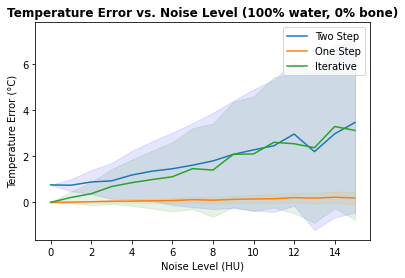

In [18]:
# INTER-METHOD VISUALIZATIONS

max_error = 16
error_level_x = np.arange(0, max_error, 1)
temp_error_all = np.empty((0, max_error))
stdev_all = np.empty((0, max_error))

k = 99 # % water
method_abbrv = ['2s', 'i', '1s']
method_names = ['two_step_algorithm', 'iterative_algorithm', 'one_step_algorithm']

for j in range(3):
    
    temp_error = np.array([])
    stdev = np.array([])
    
    for i in error_level_x:
        path = (r'C:\Users\Nathan\Deep Learning\ct-thermometry\simulation_data\%s\%s_error_level_%s_percent_water_%s.xlsx' 
                % (str(method_names[j]), str(method_abbrv[j]), str(i), str(k)))
        
        df = pd.read_excel(path)
        df = df.drop('Unnamed: 0', axis=1)

        actual_temp = df[0]
        pred_temp = df[1]
        error = np.absolute(actual_temp - pred_temp)
        
        temp_error = np.append(temp_error, np.mean(error))
        stdev = np.append(stdev, math.sqrt(np.mean(np.square(df[2]/10))))
        
       # print(df[2]/10)
    
    temp_error = np.expand_dims(temp_error, axis=0)
    stdev = np.expand_dims(stdev, axis=0)
    
    temp_error_all = np.concatenate((temp_error_all, temp_error), axis=0)
    stdev_all = np.concatenate((stdev_all, stdev), axis=0)
    
error_2s = temp_error_all[0]
error_i = temp_error_all[1]
error_1s = temp_error_all[2]

#plt.figure(figsize=(3, 4.8))
plt.plot(error_level_x, error_2s, label = 'Two Step')
plt.plot(error_level_x, error_1s, label = 'One Step')
plt.plot(error_level_x, error_i, label = 'Iterative')
plt.legend()

plt.title('Temperature Error vs. Noise Level (100% water, 0% bone)', fontweight='bold')
plt.ylabel('Temperature Error (°C)')
plt.xlabel('Noise Level (HU)')

z = 1
ci_2s =  z * stdev_all[0]
ci_i = z * stdev_all[1]
ci_1s = z * stdev_all[2]

plt.fill_between(error_level_x, (error_2s-ci_2s), (error_2s+ci_2s), color='blue', alpha = 0.1)
plt.fill_between(error_level_x, (error_1s-ci_1s), (error_1s+ci_1s), color='orange', alpha = 0.1)
plt.fill_between(error_level_x, (error_i-ci_i), (error_i+ci_i), color='green', alpha = 0.1)

plt.show()

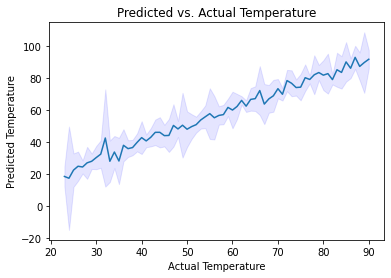

In [12]:
# INTRA-METHOD STATISTICS

i=2.0
path = r'simulation_data\two_step_algorithm\error_level_' + str(i) + '.xlsx'
df = pd.read_excel(path)
df = df.drop('Unnamed: 0', axis=1)

actual_temp = df[0]
pred_temp = df[1]
stdev_pred_temp = df[2]
mae_temp = df[3]
mae_vol_frac = df[4]

ci = 1.96 * stdev_pred_temp

plt.plot(actual_temp, pred_temp)

plt.title('Predicted vs. Actual Temperature')
plt.ylabel('Predicted Temperature')
plt.xlabel('Actual Temperature')

plt.fill_between(actual_temp, (pred_temp-ci), (pred_temp+ci), color='b', alpha=.1)

plt.show()

In [10]:
# code archive

# initialization
# current_vars = [0, 0, 1]
# penalty = 100

# def f(current_vars):
#     V_w = current_vars[0]
#     V_b = current_vars[1]
#     deltaT = current_vars[2]
    
#     return (noisy_voxel_mu - V_w * water_mu - V_b * bone_mu
#             - deltaT * (water_alphas_mu + bone_alphas))

# def J(current_vars):
#     return np.mean(np.square(f(current_vars)))

# def partialJ(current_vars, var):    
#     V_w = current_vars[0]
#     V_b = current_vars[1]
#     deltaT = current_vars[2]
    
#     if var == 'V_w':
#         return (2 * np.multiply(f(current_vars), -water_mu) + penalty * 
#                (noisy_delta_mu[0] - deltaT*water_alphas[0]*V_w - deltaT*bone_alphas[0]*V_b) * -deltaT*water_alphas[0])
#     elif var == 'V_b':
#         return (2 * np.multiply(f(current_vars), -bone_mu) + penalty *
#                (noisy_delta_mu[0] - deltaT*water_alphas[0]*V_w - deltaT*bone_alphas[0]*V_b) * -deltaT*bone_alphas[0])
#     elif var == 'deltaT':
#         return (2 * np.multiply(f(current_vars), (water_alphas_mu + bone_alphas)) + penalty *
#                (noisy_delta_mu[0] - deltaT*water_alphas[0]*V_w - deltaT*bone_alphas[0]*V_b) * (-V_w * water_alphas[0] - V_b * bone_alphas[0]))
    
# def gradient_step(current_vars, LR):
#     V_w = current_vars[0]
#     V_b = current_vars[1]
#     deltaT = current_vars[2]
    
#     #print(partialJ(current_vars, 'V_w'))
#     V_w2 = V_w - LR * np.mean(partialJ(current_vars, 'V_w'))
#     #print(partialJ(current_vars, 'V_b'))
#     V_b2 = V_b - LR * np.mean(partialJ(current_vars, 'V_b'))
#     #print(partialJ(current_vars, 'deltaT'))
#     deltaT2 = deltaT - LR * np.mean(partialJ(current_vars, 'deltaT'))
    
#     current_vars = [V_w2, V_b2, deltaT2] # simultaneous update
    
#     return current_vars

# for i in range(1000):
#     print(current_vars)
#     current_vars = gradient_step(current_vars, 0.2)
#     print(current_vars)
#     #print(J(current_vars))

%%time
1+1

UsageError: Line magic function `%%time` not found.


-0.4893734890543751